%%<br>
Cell 1: Imports and data loading

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import treescope

Add parent directory to path for imports

In [2]:
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [3]:
utils_dir = os.path.join(parent_dir, 'utils')
if utils_dir not in sys.path:
    sys.path.append(utils_dir)

In [4]:
from load_meso_session import MesoscopeSession

In [5]:
print("=== COVARIATE PREPROCESSING VALIDATION ===")

=== COVARIATE PREPROCESSING VALIDATION ===


Load preprocessed session

In [6]:
session_file = "../DATA/session_61f260e7-b5d3-4865-a577-bcfc53fda8a8.h5"
session = MesoscopeSession.from_preprocessed(session_file)
print(f"Session loaded: {session.eid}")
print(f"Subject: {session.subject}, Date: {session.date}")

Preprocessed session loaded from ../DATA/session_61f260e7-b5d3-4865-a577-bcfc53fda8a8.h5
Shape: (19081, 6903) (time_points x neurons)
EID: 61f260e7-b5d3-4865-a577-bcfc53fda8a8, Subject: SP066
Session loaded: 61f260e7-b5d3-4865-a577-bcfc53fda8a8
Subject: SP066, Date: 2025-04-09T12:10:56.318000


Load all data from HDF5

In [7]:
with h5py.File(session_file, 'r') as f:
    activity = f['activity'][:]
    covariate_matrix = f['covariate_matrix'][:]
    timestamps = f['timestamps'][:]
    feature_names = [name.decode('utf-8') for name in f['covariate_metadata']['feature_names'][:]]

In [8]:
print(f"✓ Activity shape: {activity.shape}")
print(f"✓ Covariate matrix shape: {covariate_matrix.shape}")
print(f"✓ Timestamps shape: {timestamps.shape}")
print(f"✓ Feature names: {feature_names}")

✓ Activity shape: (19081, 6903)
✓ Covariate matrix shape: (19081, 11)
✓ Timestamps shape: (19081,)
✓ Feature names: ['wheel_velocity', 'stimulus_catch_trial', 'stimulus_left_100pct', 'stimulus_left_25pct', 'stimulus_left_12.5pct', 'stimulus_left_6.25pct', 'stimulus_right_100pct', 'stimulus_right_25pct', 'stimulus_right_12.5pct', 'stimulus_right_6.25pct', 'trial_phase']


Extract covariate features

In [9]:
wheel_velocity = covariate_matrix[:, 0]
stimulus_features = covariate_matrix[:, 1:10]  # 9 stimulus types
trial_phase = covariate_matrix[:, 10]

%%<br>
Cell 2: Treescope data visualization

In [10]:
treescope.basic_interactive_setup(autovisualize_arrays=True)

Create stacked arrays for treescope visualization

In [11]:
sample_window = slice(1000, 2000)  # 1000 samples for visualization

Stack different data types for comparison

In [12]:
neural_sample = activity[sample_window, :50]  # First 50 neurons
covariate_sample = covariate_matrix[sample_window]
timestamps_sample = timestamps[sample_window]

Create combined arrays for treescope

In [13]:
data_stack = np.column_stack([
    timestamps_sample,
    wheel_velocity[sample_window], 
    trial_phase[sample_window],
    np.mean(activity[sample_window], axis=1)  # Mean neural activity
])

In [14]:
stimulus_stack = stimulus_features[sample_window]

In [15]:
print("Data arrays for treescope visualization:")
print("data_stack: [timestamps, wheel_velocity, trial_phase, mean_activity]")
print("stimulus_stack: [9 stimulus types]")
print("neural_sample: [1000 timepoints x 50 neurons]")

Data arrays for treescope visualization:
data_stack: [timestamps, wheel_velocity, trial_phase, mean_activity]
stimulus_stack: [9 stimulus types]
neural_sample: [1000 timepoints x 50 neurons]


In [16]:
data_stack  # This will be visualized by treescope
stimulus_stack  # This will be visualized by treescope
neural_sample  # This will be visualized by treescope

array([[0.04529396, 0.03018371, 0.09983321, ..., 0.45058683, 0.07896944,
        0.12988415],
       [0.00924871, 0.05332015, 0.08237949, ..., 0.31592265, 0.08032857,
        0.17697571],
       [0.03904011, 0.02086069, 0.07324132, ..., 0.29485047, 0.06975515,
        0.15873176],
       ...,
       [0.0134186 , 0.05611356, 0.06166754, ..., 0.2556199 , 0.16395564,
        0.06614062],
       [0.03434195, 0.04951496, 0.06155292, ..., 0.5790759 , 0.11283462,
        0.05351813],
       [0.01265589, 0.0827268 , 0.07592946, ..., 0.92801034, 0.10128419,
        0.03104211]], shape=(1000, 50), dtype=float32)

%%<br>
Cell 3: Rastermap-style visualization with covariates

In [17]:
def create_stimulus_overlay(stimulus_features, xmin_idx, xmax_idx):
    """Create a colored overlay for stimulus types"""
    stim_window = stimulus_features[xmin_idx:xmax_idx]
    
    # Colors for each stimulus type (matching analysis file)
    colors = [
        [0.5, 0, 0.5, 0.5],  # 0: Purple (catch trials)
        [1, 0, 0, 0.5],      # 1: Left 100% - dark red
        [1, 0.3, 0.3, 0.5],  # 2: Left 25% - medium red
        [1, 0.5, 0.5, 0.5],  # 3: Left 12.5% - light red
        [1, 0.7, 0.7, 0.5],  # 4: Left 6.25% - very light red
        [0, 0, 1, 0.5],      # 5: Right 100% - dark blue
        [0.3, 0.3, 1, 0.5],  # 6: Right 25% - medium blue
        [0.5, 0.5, 1, 0.5],  # 7: Right 12.5% - light blue
        [0.7, 0.7, 1, 0.5]   # 8: Right 6.25% - very light blue
    ]
    
    # Convert to stimulus type indices
    stim_types = np.argmax(stim_window, axis=1)
    
    # Create RGBA overlay
    nn = activity.shape[1]  # Number of neurons
    overlay = np.zeros((nn, len(stim_types), 4))  # RGBA
    
    for t, stim_type in enumerate(stim_types):
        if np.any(stim_window[t]):  # Only color if there's a stimulus
            overlay[:, t] = colors[stim_type]
    
    return overlay

In [18]:
def plot_wheel_velocity(ax, wheel_velocity, xmin_idx, xmax_idx):
    """Plot wheel velocity trace"""
    wheel_vel_window = wheel_velocity[xmin_idx:xmax_idx]
    time_indices = np.arange(len(wheel_vel_window))
    
    ax.plot(time_indices, wheel_vel_window, color='green', linewidth=1, alpha=0.8)
    ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5, linestyle='--')
    ax.set_ylabel('Wheel Velocity (rad/s)', color='green')
    ax.tick_params(axis='y', labelcolor='green')
    ax.set_xlim(0, len(wheel_vel_window))
    
    vel_max = np.max(np.abs(wheel_vel_window))
    if vel_max > 0:
        ax.set_ylim(-vel_max*1.1, vel_max*1.1)
    else:
        ax.set_ylim(-0.1, 0.1)

Define time window (raw sample indices, not minutes/hours)

Create visualization similar to analysis file

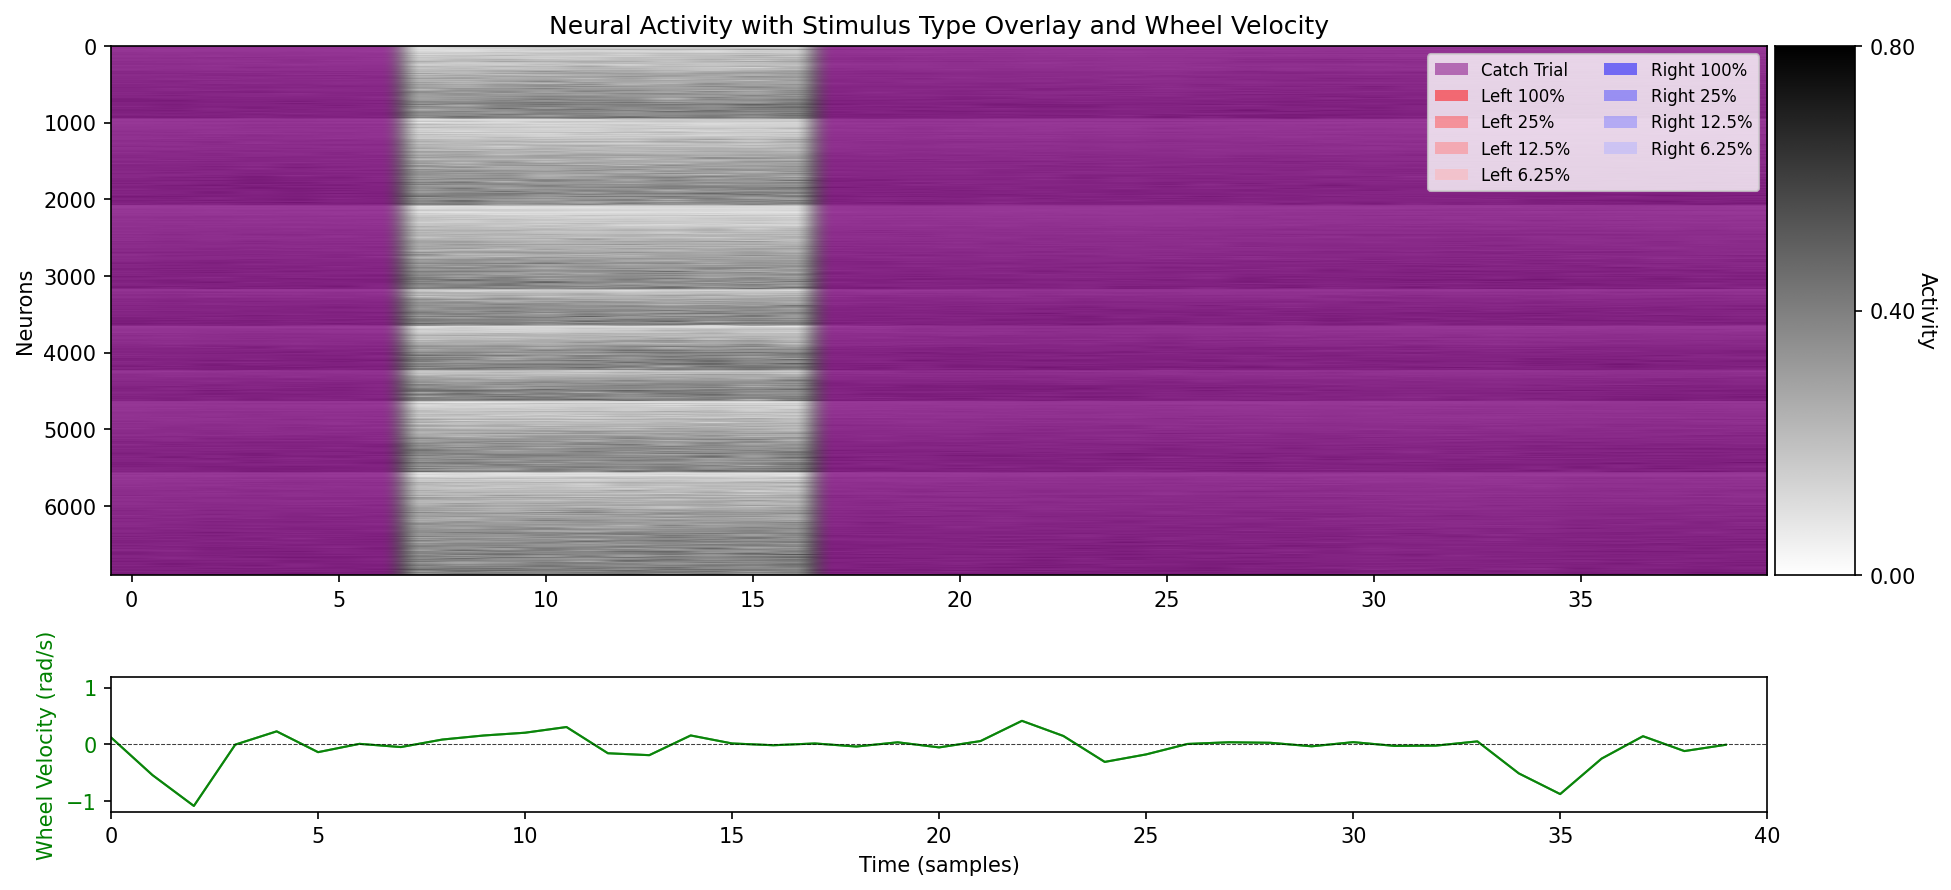


Window statistics (samples 500-540):
  Velocity range: -1.084 to 0.417 rad/s
  Non-zero velocity: 40/40 (100.0%)
  Trial phase active: 30.0/40 samples


In [19]:
xmin_idx = 500
xmax_idx = 540
fig = plt.figure(figsize=(15, 8), dpi=150)
grid = plt.GridSpec(12, 20, figure=fig, wspace=0.1, hspace=0.4)
ax_raster = plt.subplot(grid[2:9, :-1])
activity_window = activity[xmin_idx:xmax_idx].T  # Transpose for neuron x time
ax_raster.imshow(activity_window, cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
stim_overlay = create_stimulus_overlay(stimulus_features, xmin_idx, xmax_idx)
ax_raster.imshow(stim_overlay, aspect="auto")
ax_raster.set_ylabel("Neurons")
ax_raster.set_title("Neural Activity with Stimulus Type Overlay and Wheel Velocity")

ax_cbar = plt.subplot(grid[2:9, -1])
activity_gradient = np.linspace(0.8, 0, activity.shape[1])[:, np.newaxis]
ax_cbar.imshow(activity_gradient, cmap="gray_r", aspect="auto", vmin=0, vmax=0.8)
ax_cbar.yaxis.set_label_position("right")
ax_cbar.set_ylabel("Activity", rotation=270, labelpad=10)
ax_cbar.set_yticks([0, activity.shape[1]//2, activity.shape[1]-1])
ax_cbar.set_yticklabels(['0.80', '0.40', '0.00'])
ax_cbar.set_xticks([])
ax_cbar.yaxis.tick_right()

ax_wheel = plt.subplot(grid[10:12, :-1])
plot_wheel_velocity(ax_wheel, wheel_velocity, xmin_idx, xmax_idx)
ax_wheel.set_xlabel("Time (samples)")

stim_overlay = create_stimulus_overlay(stimulus_features, xmin_idx, xmax_idx)
ax_raster.imshow(stim_overlay, aspect="auto")

ax_raster.set_ylabel("Neurons")
ax_raster.set_title("Neural Activity with Stimulus Type Overlay and Wheel Velocity")

ax_cbar = plt.subplot(grid[2:9, -1])
activity_gradient = np.linspace(0.8, 0, activity.shape[1])[:, np.newaxis]
ax_cbar.imshow(activity_gradient, cmap="gray_r", aspect="auto", vmin=0, vmax=0.8)
ax_cbar.yaxis.set_label_position("right")
ax_cbar.set_ylabel("Activity", rotation=270, labelpad=10)
ax_cbar.set_yticks([0, activity.shape[1]//2, activity.shape[1]-1])
ax_cbar.set_yticklabels(['0.80', '0.40', '0.00'])
ax_cbar.set_xticks([])
ax_cbar.yaxis.tick_right()

ax_wheel = plt.subplot(grid[10:12, :-1])
plot_wheel_velocity(ax_wheel, wheel_velocity, xmin_idx, xmax_idx)
ax_wheel.set_xlabel("Time (samples)")

legend_elements = [
    patches.Patch(facecolor=(0.5, 0, 0.5, 0.5), label='Catch Trial'),
    patches.Patch(facecolor=(1, 0, 0, 0.5), label='Left 100%'),
    patches.Patch(facecolor=(1, 0.3, 0.3, 0.5), label='Left 25%'),
    patches.Patch(facecolor=(1, 0.5, 0.5, 0.5), label='Left 12.5%'),
    patches.Patch(facecolor=(1, 0.7, 0.7, 0.5), label='Left 6.25%'),
    patches.Patch(facecolor=(0, 0, 1, 0.5), label='Right 100%'),
    patches.Patch(facecolor=(0.3, 0.3, 1, 0.5), label='Right 25%'),
    patches.Patch(facecolor=(0.5, 0.5, 1, 0.5), label='Right 12.5%'),
    patches.Patch(facecolor=(0.7, 0.7, 1, 0.5), label='Right 6.25%')
]
ax_raster.legend(handles=legend_elements, loc='upper right', fontsize=8, ncol=2)

plt.show()
vel_window = wheel_velocity[xmin_idx:xmax_idx]
print(f"\nWindow statistics (samples {xmin_idx}-{xmax_idx}):")
print(f"  Velocity range: {np.min(vel_window):.3f} to {np.max(vel_window):.3f} rad/s")
print(f"  Non-zero velocity: {np.sum(vel_window != 0)}/{len(vel_window)} ({100*np.sum(vel_window != 0)/len(vel_window):.1f}%)")
print(f"  Trial phase active: {np.sum(trial_phase[xmin_idx:xmax_idx])}/{xmax_idx-xmin_idx} samples")

Colorbar

Plot wheel velocity below

Text(0.5, 0, 'Time (samples)')

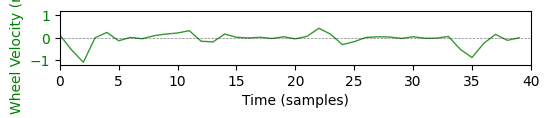

In [20]:
ax_wheel = plt.subplot(grid[10:12, :-1])
plot_wheel_velocity(ax_wheel, wheel_velocity, xmin_idx, xmax_idx)
ax_wheel.set_xlabel("Time (samples)")

Create legend for stimulus types

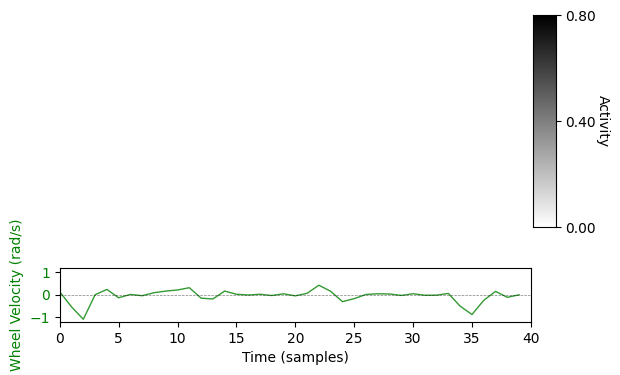


Window statistics (samples 500-540):
  Velocity range: -1.084 to 0.417 rad/s
  Non-zero velocity: 40/40 (100.0%)
  Trial phase active: 30.0/40 samples


In [21]:
stim_overlay = create_stimulus_overlay(stimulus_features, xmin_idx, xmax_idx)
ax_raster.imshow(stim_overlay, aspect="auto")

ax_raster.set_ylabel("Neurons")
ax_raster.set_title("Neural Activity with Stimulus Type Overlay and Wheel Velocity")

ax_cbar = plt.subplot(grid[2:9, -1])
activity_gradient = np.linspace(0.8, 0, activity.shape[1])[:, np.newaxis]
ax_cbar.imshow(activity_gradient, cmap="gray_r", aspect="auto", vmin=0, vmax=0.8)
ax_cbar.yaxis.set_label_position("right")
ax_cbar.set_ylabel("Activity", rotation=270, labelpad=10)
ax_cbar.set_yticks([0, activity.shape[1]//2, activity.shape[1]-1])
ax_cbar.set_yticklabels(['0.80', '0.40', '0.00'])
ax_cbar.set_xticks([])
ax_cbar.yaxis.tick_right()

ax_wheel = plt.subplot(grid[10:12, :-1])
plot_wheel_velocity(ax_wheel, wheel_velocity, xmin_idx, xmax_idx)
ax_wheel.set_xlabel("Time (samples)")

legend_elements = [
    patches.Patch(facecolor=(0.5, 0, 0.5, 0.5), label='Catch Trial'),
    patches.Patch(facecolor=(1, 0, 0, 0.5), label='Left 100%'),
    patches.Patch(facecolor=(1, 0.3, 0.3, 0.5), label='Left 25%'),
    patches.Patch(facecolor=(1, 0.5, 0.5, 0.5), label='Left 12.5%'),
    patches.Patch(facecolor=(1, 0.7, 0.7, 0.5), label='Left 6.25%'),
    patches.Patch(facecolor=(0, 0, 1, 0.5), label='Right 100%'),
    patches.Patch(facecolor=(0.3, 0.3, 1, 0.5), label='Right 25%'),
    patches.Patch(facecolor=(0.5, 0.5, 1, 0.5), label='Right 12.5%'),
    patches.Patch(facecolor=(0.7, 0.7, 1, 0.5), label='Right 6.25%')
]
ax_raster.legend(handles=legend_elements, loc='upper right', fontsize=8, ncol=2)

plt.show()
vel_window = wheel_velocity[xmin_idx:xmax_idx]
print(f"\nWindow statistics (samples {xmin_idx}-{xmax_idx}):")
print(f"  Velocity range: {np.min(vel_window):.3f} to {np.max(vel_window):.3f} rad/s")
print(f"  Non-zero velocity: {np.sum(vel_window != 0)}/{len(vel_window)} ({100*np.sum(vel_window != 0)/len(vel_window):.1f}%)")
print(f"  Trial phase active: {np.sum(trial_phase[xmin_idx:xmax_idx])}/{xmax_idx-xmin_idx} samples")

In [22]:
plt.show()

Print statistics for this window

In [23]:
vel_window = wheel_velocity[xmin_idx:xmax_idx]
print(f"\nWindow statistics (samples {xmin_idx}-{xmax_idx}):")
print(f"  Velocity range: {np.min(vel_window):.3f} to {np.max(vel_window):.3f} rad/s")
print(f"  Non-zero velocity: {np.sum(vel_window != 0)}/{len(vel_window)} ({100*np.sum(vel_window != 0)/len(vel_window):.1f}%)")
print(f"  Trial phase active: {np.sum(trial_phase[xmin_idx:xmax_idx])}/{xmax_idx-xmin_idx} samples")


Window statistics (samples 500-540):
  Velocity range: -1.084 to 0.417 rad/s
  Non-zero velocity: 40/40 (100.0%)
  Trial phase active: 30.0/40 samples


%%<br>
Cell 4: Dataset_Activity testing and validation summary

In [24]:
class SimpleDatasetTest:
    """Simplified Dataset_Activity for testing covariate loading"""
    
    def __init__(self, h5_file_path, seq_len=96, label_len=48, pred_len=96):
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        self.h5_file_path = h5_file_path
        self._load_data()
        
    def _load_data(self):
        with h5py.File(self.h5_file_path, 'r') as f:
            self.neural_data = f['activity'][:]
            self.timestamps = f['timestamps'][:]
            self.covariate_data = f['covariate_matrix'][:]
            self.feature_names = [name.decode('utf-8') for name in f['covariate_metadata']['feature_names'][:]]
        
        print(f"Dataset loaded: neural {self.neural_data.shape}, covariates {self.covariate_data.shape}")
        
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        
        seq_x = self.neural_data[s_begin:s_end]
        seq_y = self.neural_data[r_begin:r_end]
        seq_x_mark = self.covariate_data[s_begin:s_end]
        seq_y_mark = self.covariate_data[r_begin:r_end]
        
        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return max(0, len(self.neural_data) - self.seq_len - self.pred_len + 1)

Test dataset functionality

In [25]:
dataset = SimpleDatasetTest(session_file)
print(f"\n=== DATASET FUNCTIONALITY TEST ===")
print(f"Dataset length: {len(dataset)}")
print(f"Feature names: {dataset.feature_names}")

Dataset loaded: neural (19081, 6903), covariates (19081, 11)

=== DATASET FUNCTIONALITY TEST ===
Dataset length: 18890
Feature names: ['wheel_velocity', 'stimulus_catch_trial', 'stimulus_left_100pct', 'stimulus_left_25pct', 'stimulus_left_12.5pct', 'stimulus_left_6.25pct', 'stimulus_right_100pct', 'stimulus_right_25pct', 'stimulus_right_12.5pct', 'stimulus_right_6.25pct', 'trial_phase']


Test sample sequences

In [26]:
for i in range(min(3, len(dataset))):
    seq_x, seq_y, seq_x_mark, seq_y_mark = dataset[i]
    
    print(f"\nSample {i}:")
    print(f"  seq_x (neural input): {seq_x.shape}")
    print(f"  seq_y (neural target): {seq_y.shape}")
    print(f"  seq_x_mark (covariate input): {seq_x_mark.shape}")
    print(f"  seq_y_mark (covariate target): {seq_y_mark.shape}")
    print(f"  Wheel velocity range in input: {seq_x_mark[:, 0].min():.3f} to {seq_x_mark[:, 0].max():.3f}")
    print(f"  Stimulus activity in input: {np.sum(seq_x_mark[:, 1:10].sum(axis=1) > 0)} samples")


Sample 0:
  seq_x (neural input): (96, 6903)
  seq_y (neural target): (144, 6903)
  seq_x_mark (covariate input): (96, 11)
  seq_y_mark (covariate target): (144, 11)
  Wheel velocity range in input: -1.112 to 0.069
  Stimulus activity in input: 0 samples

Sample 1:
  seq_x (neural input): (96, 6903)
  seq_y (neural target): (144, 6903)
  seq_x_mark (covariate input): (96, 11)
  seq_y_mark (covariate target): (144, 11)
  Wheel velocity range in input: -1.112 to 0.069
  Stimulus activity in input: 0 samples

Sample 2:
  seq_x (neural input): (96, 6903)
  seq_y (neural target): (144, 6903)
  seq_x_mark (covariate input): (96, 11)
  seq_y_mark (covariate target): (144, 11)
  Wheel velocity range in input: -1.112 to 0.848
  Stimulus activity in input: 0 samples


Overall statistics

In [27]:
print(f"\n📈 DATA SUMMARY:")
print(f"  • Neural activity: {activity.shape[0]} timepoints × {activity.shape[1]} neurons")
print(f"  • Covariate matrix: {covariate_matrix.shape[0]} timepoints × {covariate_matrix.shape[1]} features")
print(f"  • Session duration: {timestamps.max()/3600:.2f} hours")
print(f"  • Sampling rate: ~{1/np.mean(np.diff(timestamps)):.1f} Hz")


📈 DATA SUMMARY:
  • Neural activity: 19081 timepoints × 6903 neurons
  • Covariate matrix: 19081 timepoints × 11 features
  • Session duration: 1.09 hours
  • Sampling rate: ~4.9 Hz


In [28]:
print(f"\n🎯 COVARIATE ACTIVITY:")
print(f"  • Wheel movement: {100*np.sum(wheel_velocity != 0)/len(wheel_velocity):.1f}% of time")
print(f"  • Stimulus periods: {100*np.sum(trial_phase)/len(trial_phase):.1f}% of time")
print(f"  • Active stimulus types: {np.sum(stimulus_features.sum(axis=0) > 0)}/9 types")


🎯 COVARIATE ACTIVITY:
  • Wheel movement: 75.3% of time
  • Stimulus periods: 60.2% of time
  • Active stimulus types: 9/9 types


Per-stimulus type statistics

In [29]:
print(f"\n📊 STIMULUS TYPE BREAKDOWN:")
stimulus_labels = ['Catch', 'L100%', 'L25%', 'L12.5%', 'L6.25%', 'R100%', 'R25%', 'R12.5%', 'R6.25%']
for i in range(9):
    stim_count = np.sum(stimulus_features[:, i])
    if stim_count > 0:
        print(f"  • {stimulus_labels[i]}: {stim_count} samples ({100*stim_count/len(stimulus_features):.2f}%)")


📊 STIMULUS TYPE BREAKDOWN:
  • Catch: 2828.0 samples (14.82%)
  • L100%: 1355.0 samples (7.10%)
  • L25%: 1586.0 samples (8.31%)
  • L12.5%: 799.0 samples (4.19%)
  • L6.25%: 1649.0 samples (8.64%)
  • R100%: 294.0 samples (1.54%)
  • R25%: 458.0 samples (2.40%)
  • R12.5%: 926.0 samples (4.85%)
  • R6.25%: 1588.0 samples (8.32%)


Temporal alignment validation

In [30]:
with h5py.File(session_file, 'r') as f:
    stimOn_times = f['trial_data']['stimOn_times'][:]
    stimOff_times = f['trial_data']['stimOff_times'][:]
    
print(f"\n⏱️ TEMPORAL ALIGNMENT:")
print(f"  • Neural data range: {timestamps.min():.2f}s to {timestamps.max():.2f}s")
print(f"  • Stimulus times range: {np.nanmin(stimOn_times):.2f}s to {np.nanmax(stimOff_times):.2f}s")
print(f"  • Total trials: {len(stimOn_times)}")


⏱️ TEMPORAL ALIGNMENT:
  • Neural data range: 1.11s to 3935.10s
  • Stimulus times range: 28.88s to 2914.71s
  • Total trials: 315


Check sample trial alignment

In [31]:
alignment_errors = 0
for trial_idx in range(min(10, len(stimOn_times))):
    stim_on = stimOn_times[trial_idx]
    stim_off = stimOff_times[trial_idx]
    
    if not (np.isnan(stim_on) or np.isnan(stim_off)):
        neural_mask = (timestamps >= stim_on) & (timestamps <= stim_off)
        trial_phase_during = trial_phase[neural_mask]
        if np.sum(trial_phase_during) == 0:
            alignment_errors += 1

In [32]:
print(f"  • Trial alignment errors: {alignment_errors}/10 sample trials")

  • Trial alignment errors: 0/10 sample trials


In [33]:
print(f"\n🚀 READY FOR DLINEAR INTEGRATION:")
if alignment_errors == 0 and len(dataset) > 0:
    print("  ✓ All validation checks passed")
    print("  ✓ Covariate data properly aligned")
    print("  ✓ Dataset_Activity integration validated")
    print("  ✓ Ready to export to DLinear repo")
else:
    print("  ⚠ Some validation issues detected")
    print("  ⚠ Review preprocessing pipeline")


🚀 READY FOR DLINEAR INTEGRATION:
  ✓ All validation checks passed
  ✓ Covariate data properly aligned
  ✓ Dataset_Activity integration validated
  ✓ Ready to export to DLinear repo


In [34]:
print("\n" + "="*60)
print("VALIDATION COMPLETE")
print("="*60)


VALIDATION COMPLETE
